In [1]:
import os
import pandas as pd
import cnmfsns as cn
cn.cli.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [2]:
data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True)

/home/tbverhey/miniconda3/lib/python3.9/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/tbverhey/github/cNMF-SNS/src/cnmfsns/dataset.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=data, var=var, uns=uns)


They can be written to and read from AnnData files (h5ad format).

In [3]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file

diamandis = cn.Dataset.from_h5ad("diamandis.h5ad")  # read a .h5ad file

2023-02-23 15:38:35,172 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-02-23 15:38:35,203 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [4]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [5]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [6]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040063,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684865e+14,3.112052e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638137,0.763087


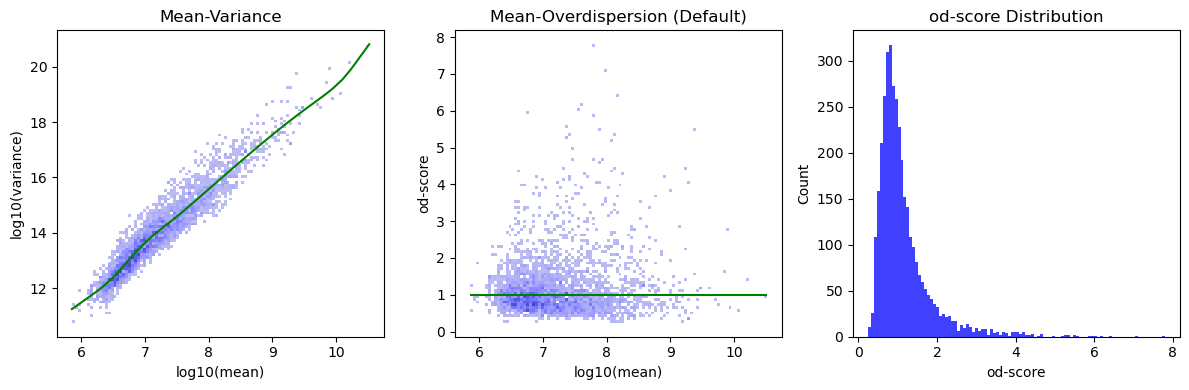

In [7]:
figs = cn.plots.plot_feature_dispersion(diamandis, show_selected=False)

## Selecting overdispersed genes

2023-02-23 15:38:36,923 [INFO] 1612 genes selected for factorization


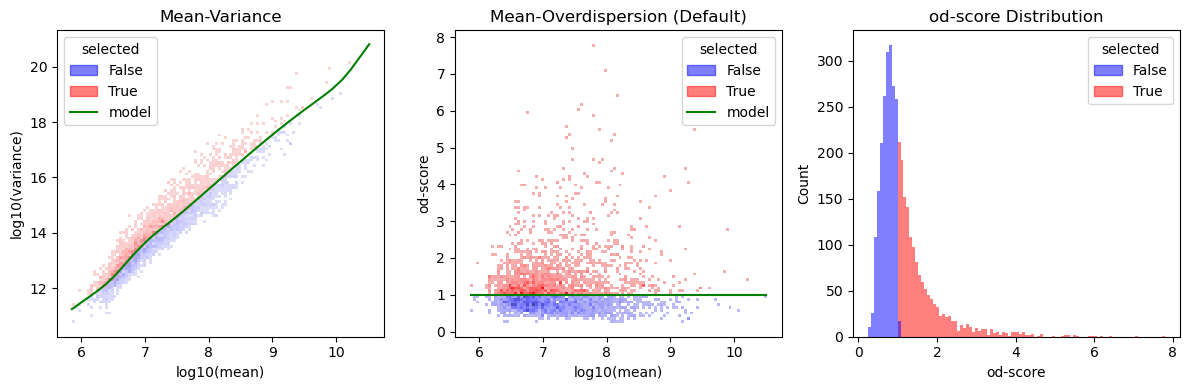

In [8]:
diamandis.select_overdispersed_genes()
figs = cn.plots.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [9]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [10]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"

# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=[2, 4, 6, 8], n_iter=10)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-02-23 15:38:40,888 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-02-23 15:38:40,888 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-02-23 15:38:40,889 [INFO] Creating consensus GEPs and usages for k=2
2023-02-23 15:38:42,422 [INFO] Creating consensus GEPs and usages for k=4
2023-02-23 15:38:44,177 [INFO] Creating consensus GEPs and usages for k=6
2023-02-23 15:38:46,148 [INFO] Creating consensus GEPs and usages for k=8
2023-02-23 15:38:52,787 [INFO] Importing GEPs: gene_spectra_score
2023-02-23 15:38:53,058 [INFO] Importing GEPs: gene_spectra_tpm
2023-02-23 15:38:53,329 [INFO] Importing GEPs: spectra
2023-02-23 15:38:53,453 [INFO] Importing Usages
2023-02-23 15:38:53,464 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-02-23 15:38:53,575 [INFO] Done


## Stability-Error Plot

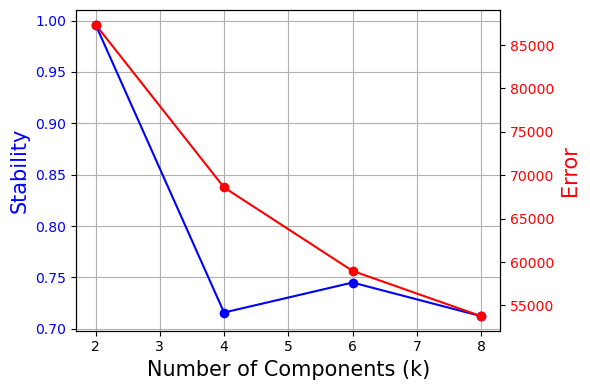

In [11]:
fig = cn.plots.plot_stability_error(diamandis)

## Plot GEP usage

2023-02-23 15:38:53,995 [INFO] Choosing distinct colors for metadata layer patient_id
2023-02-23 15:38:54,137 [INFO] Choosing distinct colors for metadata layer simple_category
2023-02-23 15:38:54,157 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-02-23 15:38:54,178 [INFO] Choosing distinct colors for metadata layer sex
2023-02-23 15:38:54,185 [INFO] Choosing distinct colors for metadata layer location of resection
2023-02-23 15:38:54,275 [INFO] Choosing distinct colors for metadata layer ATRX
2023-02-23 15:38:54,283 [INFO] Choosing distinct colors for metadata layer p53
2023-02-23 15:38:54,293 [INFO] Choosing distinct colors for metadata layer MGMT


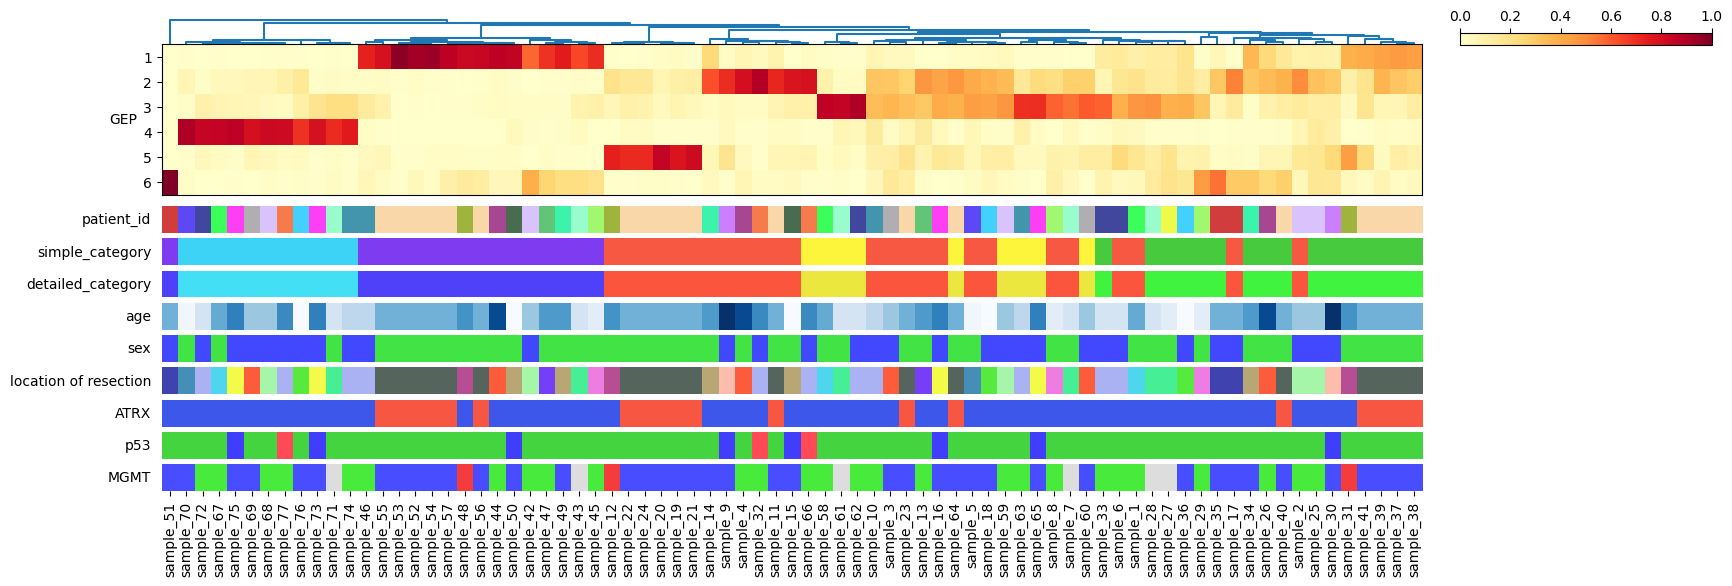

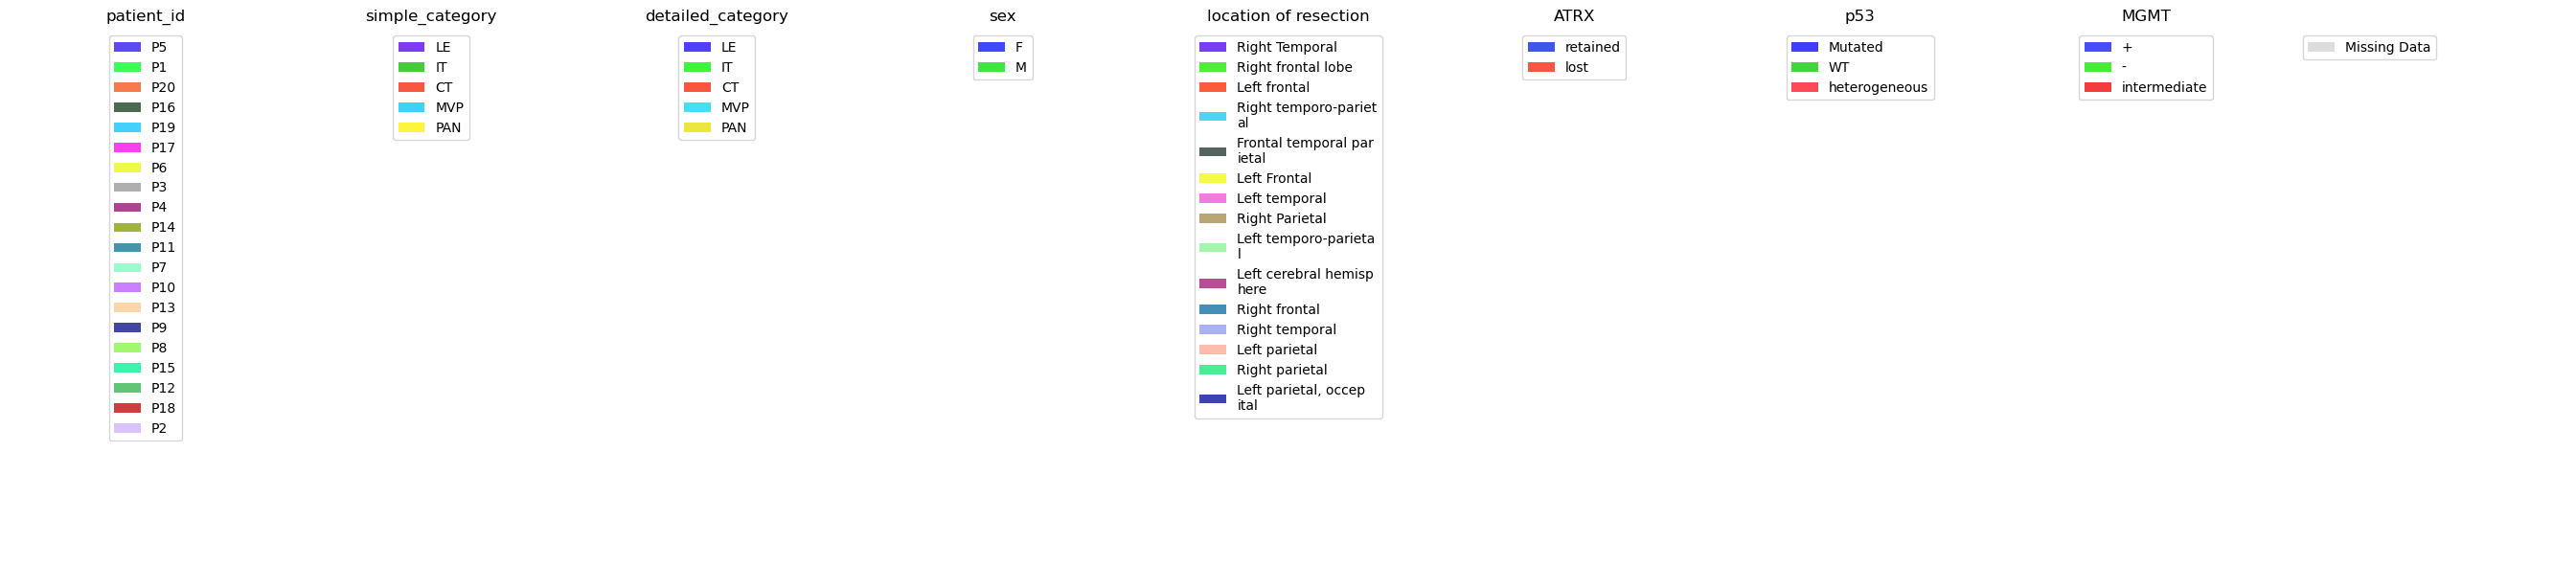

In [12]:
config = cn.Config()  # create empty configuration with default values
config.add_missing_metadata_colors(diamandis, pastel_factor=0.3)  # creates visually distinct colors for metadata tracks

fig = cn.plots.plot_annotated_usages(diamandis, k=6, metadata_colors=config.metadata_colors)
fig.savefig("k6_usages_heatmap.pdf")
fig_legend = config.plot_metadata_colors_legend()
fig.savefig("metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [2]:

data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True)
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=[2, 4, 6, 8], n_iter=10)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

/home/tbverhey/github/cNMF-SNS/src/cnmfsns/dataset.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=data, var=var, uns=uns)
2023-02-23 15:42:36,519 [INFO] 4554 genes selected for factorization
2023-02-23 15:43:17,957 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-02-23 15:43:17,959 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-02-23 15:43:17,961 [INFO] Creating consensus GEPs and usages for k=2


ValueError: Array with wrong shape passed to NMF (input H). Expected (2, 4554), but got (2, 1612) 

## Integrate multiple datasets together

In [ ]:
datasets = {"CPTAC GBM": cptac,
            "Diamandis": dataset}


dataset.adata.uns["kvals"].index

Int64Index([2, 4, 6, 8], dtype='int64', name='k')